In [1]:
#library & package. 
#Jalankan ulang jika menambahkan library baru
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json 
import re, string
import tweepy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

basePath="./"

## Part 1 : Data Collection

#### Soal 1
*Instruksi Soal* : Apa kata kunci yang ingin kalian cari di twitter dan kenapa. jelaskan singkat pada sel ini

*Catatan* :

Pada tugas ini, akan diambil data pada twitter dengan menggunakan api yang disediakan oleh twitter. Adapun kata kunci pada pencarian ini adalah "ppkm".
Pencarian ini dilakukan mengingat ada perubahan pemerintah mengenai kebijakan ppkm yang semulanya akan diperketat pada akhir tahun baru, namun kini kebijakan tersebut dibatalkan. Dengan perubahan kebijakan itu, saya ingin mengeksplorasi lebih jauh setidaknya dua hal. 
1. Opini umum warganet mengenai perubahan kebijakan tersebut
2. Bagaimana sentimen warganet


#### Soal 2
*Instruksi Soal* : 

Ambil data pada twitter dengan kata kunci tersebut. ambil sebanyak 300 tweet. masukkan pada datarame dan tampilkan dataframenya


Catatan :
1. Karena saya akan mengakses api tweet publik (yang tidak perlu menyertakan konteks user) maka autentikasi yang digunakan tidak perlu menyertakan access token & access token secret. 
2. Keyword pencarian pada request data adalah ppkm dengan memfilter bahasa yang digunakan dan mengecualikan retweet pada permintaan data
3. Untuk menhindari perubahan analisis dan limitasi jumlah request pada twitter, maka request dilakukan hanya satu kali, kemudian data twitter disimpan di dalam file csv

In [9]:
# read token from a file
with open(f"{basePath}token.json")as f:
  tokens = json.load(f)

print(tokens.keys())

dict_keys(['bearer_token', 'api_key', 'api_key_secret', 'access_token', 'access_token_secret'])


In [10]:
auth = tweepy.AppAuthHandler(
    tokens["api_key"], 
    tokens["api_key_secret"]
)

keyword = "ppkm"
api = tweepy.API(auth)
data = []
for tweet in tweepy.Cursor(
    api.search_tweets, 
    q=f'{keyword} -filter:retweets', 
    tweet_mode="extended",
    lang="in"
    ).items(300):
    data.append({
        "id": tweet.id, 
        "tweet": tweet.full_text 
    })

df = pd.DataFrame(data)
# df = pd.read_csv("./data_tweet.csv")
display(df)

df.to_csv("data_tweet.csv", index=False)

,id,tweet
0,1468240056695541775,"ppkm batal. sesuk nak kasus e munggah meneh, tenan aku arep JIM sik dadi warga negara. arep fokus belajar bahasa korea."
1,1468239974898319378,PPKM Level 3 diundur sampe menjelang Ramadhan dan Idul Fitri nanti..🙊🙊 https://t.co/ohmSaTZfFw
2,1468239969328246789,oh gajadi ppkm takut ora iso nyekar ke tmpt opung
3,1468239953297612812,"Bersama Forkopimda Palas, Dandim 0212/Tapsel Laksanakan Rapat Evaluasi PPKM dan Vaksinasi https://t.co/i0Mh847RZT"
4,1468239726809391111,Kebijakan PPKM level 3 di seluruh wilayah Indonesia saat Natal dan Tahun Baru dibatalkan. Bagaimana nasib libur semester ganjil? Via: detikedu https://t.co/PaMv6INLes
...,...,...
295,1468227167599448074,@tempodotco PPKM sama kaga PPKM kga ngaruh tetep ajah pendapatan runyem
296,1468227128172990470,DISKRIMINASI LEVEL 3 !!!!\n\nPemerintah Tidak Jadi Berlakukan PPKM Level 3 Selama Libur Natal dan Tahun Baru 2022 https://t.co/sAMnStqe1g
297,1468227111324459017,Pemerintah Batal Terapkan PPKM Level 3 Seluruh Indonesia Saat Nataru \n\nhttps://t.co/UzZL8rJiIL
298,1468227031326412802,Selasa JNE Memberi PPKM Nataru Genangan Rumini Lebaran Idul Fitri Basarnas \n\n#IndonesiaUntukSemeru\n#KadrunHamaNKRI https://t.co/T7wo4nDGHN


### Part 2 : Data Cleaning & Preprocessing

#### Soal 3

Instruksi Soal:

- Lakukan Text Preprocessing (lakukan sebaik mungkin). 
- Masukkan pada dataframe kalian dengan nama kolom tweet_clean.
- jangan lupa lakukan pembersihan slang word/bahasa gaul
- Tampilkan dataframe

In [11]:

pd.set_option('display.max_colwidth', None)

class TweetAnalyzer:
  slangs = {
      "yg": "", 
      "dg": "", 
      "thd": "", 
      "dr": "", 
      "drpd": "",
      "aja": "",
      "jd": "",
      "lg": "",
      "tak": "tidak",
      "tdk": "tidak",
      "gak": "tidak", 
      "engga": "tidak",
      "enggak": "tidak", 
      "ga": "tidak", 
      "g": "tidak", 
      "blm": "belum",
      "tp": "tapi", 
      "belom": "belum", 
      "jgn": "jangan", 
      "bkn": "bukan"
    }  

  def __init__(self, df):
    self.df = df.copy()
    self.blackList = stopwords.words('indonesian')
    self.cleanTweet()

  def cleanTweet(self):
    # 1. case folding
    # 2. remove / replace slangs
      # merubah / mengganti kata slang umum yang biasa 
      # digunakan dalam percakapan
      # untuk kata hubung, saya putuskan untuk menghapusnya, sedangkan untuk 
      # kata lain saya ganti dengan kata formal bahasa indonesia
    # 3. removeStopWords
    # 4. stemming

    self.df["tweet_clean"] = self.df["tweet"].apply(self.caseFolding)
    self.replaceSlang(slangs=TweetAnalyzer.slangs)
    self.df["tweet_clean"] = self.df["tweet_clean"].apply(self.removeStopWords)   
    # self.df["tweet_clean"] = self.df["tweet_clean"].apply(self.stemming) 

  def showHead(
    self,
    columns=["tweet", "id", "tweet_clean"],
    n=5
  ):
    display(self.df[columns].head(n)) 

  def caseFolding(self, text):
    # 1. convert to lower case
    # 2. replace digit & link with a whitespace 
    # 3. remove &amp \n or \t
    # 4. remove white space
    # 5. remove punctuation
    text = text.lower()
    text = re.sub(r"\d+|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
    text = text.strip()
    text = text.translate(text.maketrans("", "", string.punctuation))
    return text
  
  def replaceSlang(self, slangs):
    self.df["tweet_clean"] = self.df["tweet_clean"].apply(self.replaceText, slangs=slangs)

  def replaceText(self, text, slangs):
    splittedText = word_tokenize(text)
    splittedText = [word if word not in slangs.keys() else (word if slangs[word]!="" else slangs[word]) for word in splittedText]
    text = " ".join(splittedText)
    text = re.sub(' +', ' ', text)
    return text

  def removeStopWords(self, text):
    text = word_tokenize(text)
    cleanText = [word for word in text if word not in self.blackList]
    return " ".join(cleanText) 

  def stemming(self, text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

  def showFqCharPerTweet(self):
    self.df["tweet_clean"].str.len().hist(bins=20)
    plt.title("Distribusi Frekuensi jumlah huruf pada suatu data")
    plt.show()

  def showNumWordPerTweet(self):
    self.df["tweet_clean"].str.split().map(lambda x: len(x)).hist(bins=20)
    plt.title("Distribusi Frekuensi jumlah kata pada suatu data")
    plt.show()
  
  def getAvgWord(self, x):
      x = x.split()
      x = map(lambda x: len(x), x)
      return(np.average(list(x)))

  def showAvgWordPerTweet(self):
    self.df["tweet_clean"].apply(self.getAvgWord).hist(bins=20)
    plt.title("Distribusi Frekuensi panjang kata rata-rata pada suatu data")
    plt.show()

  def genAllWord(self): 
    self.df["tokenize"] = self.df["tweet_clean"].apply(lambda x: x.split(" ")) 
    self.allWord = [word for tweet in self.df["tokenize"] for word in tweet]
    
  def freqWordDist(self, nWord=20):
    self.genAllWord()
    print("Distribusi Frekuensi kata yang sering keluar")
    fqdist = FreqDist(self.allWord)
    fqdist.plot(nWord, cumulative=False)

  def nGramsDist(self, n=2, nWord=20):
    self.genAllWord()
    result = pd.Series(ngrams(self.allWord, n)).value_counts()[:nWord]
    print(f"#Distribusi N-gram (n={n})")
    print(result)
  
  def genWordCloud(self):
    self.genAllWord()
    wordcloud = WordCloud(
      random_state=1,
      background_color='black',
      colormap='Pastel1', 
      max_words=100,
      collocations=False  
    ).generate(" ".join(self.allWord))
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis("off")

# Membaca data tweet pada file & membuat object TweetAnalyzer
df = pd.read_csv("data_tweet.csv")
analyze = TweetAnalyzer(df)

# Menampilkan hasil pembersihan
analyze.df

,id,tweet,tweet_clean
0,1468240056695541775,"ppkm batal. sesuk nak kasus e munggah meneh, tenan aku arep JIM sik dadi warga negara. arep fokus belajar bahasa korea.",ppkm batal sesuk nak e munggah meneh tenan arep jim sik dadi warga negara arep fokus belajar bahasa korea
1,1468239974898319378,PPKM Level 3 diundur sampe menjelang Ramadhan dan Idul Fitri nanti..🙊🙊 https://t.co/ohmSaTZfFw,ppkm level diundur sampe menjelang ramadhan idul fitri
2,1468239969328246789,oh gajadi ppkm takut ora iso nyekar ke tmpt opung,oh gajadi ppkm takut ora iso nyekar tmpt opung
3,1468239953297612812,"Bersama Forkopimda Palas, Dandim 0212/Tapsel Laksanakan Rapat Evaluasi PPKM dan Vaksinasi https://t.co/i0Mh847RZT",forkopimda palas dandim tapsel laksanakan rapat evaluasi ppkm vaksinasi
4,1468239726809391111,Kebijakan PPKM level 3 di seluruh wilayah Indonesia saat Natal dan Tahun Baru dibatalkan. Bagaimana nasib libur semester ganjil? Via: detikedu https://t.co/PaMv6INLes,kebijakan ppkm level wilayah indonesia natal dibatalkan nasib libur semester ganjil via detikedu
...,...,...,...
295,1468227167599448074,@tempodotco PPKM sama kaga PPKM kga ngaruh tetep ajah pendapatan runyem,ppkm kaga ppkm kga ngaruh tetep ajah pendapatan runyem
296,1468227128172990470,DISKRIMINASI LEVEL 3 !!!!\n\nPemerintah Tidak Jadi Berlakukan PPKM Level 3 Selama Libur Natal dan Tahun Baru 2022 https://t.co/sAMnStqe1g,diskriminasi level pemerintah berlakukan ppkm level libur natal
297,1468227111324459017,Pemerintah Batal Terapkan PPKM Level 3 Seluruh Indonesia Saat Nataru \n\nhttps://t.co/UzZL8rJiIL,pemerintah batal terapkan ppkm level indonesia nataru
298,1468227031326412802,Selasa JNE Memberi PPKM Nataru Genangan Rumini Lebaran Idul Fitri Basarnas \n\n#IndonesiaUntukSemeru\n#KadrunHamaNKRI https://t.co/T7wo4nDGHN,selasa jne ppkm nataru genangan rumini lebaran idul fitri basarnas indonesiauntuksemeru kadrunhamankri


### Part 3 : Text Analysis

*Instruksi Soal*

1. lakukan semua Text Analysis, seperti word_frequency, mean_word_length, dsb. tampilkan plot dari setiap analysis
3. dengan melihat word_frequency coba perbaiki pembersihan slang word pada tweet_clean
4. tampilkan dataframe kalian


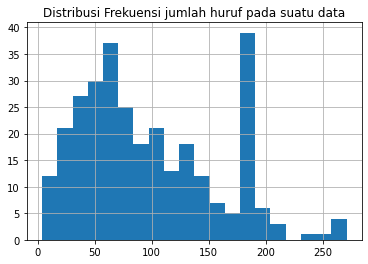

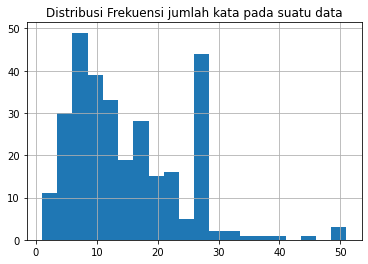

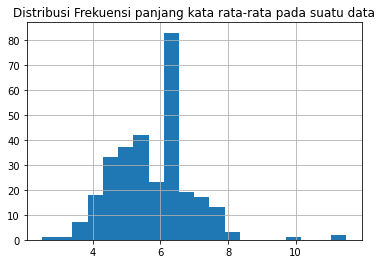

Distribusi Frekuensi kata yang sering keluar


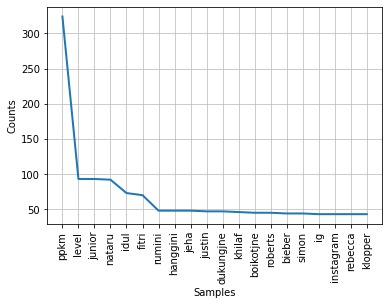

#Distribusi N-gram (n=2)
(ppkm, level)             88
(idul, fitri)             70
(junior, roberts)         45
(hanggini, junior)        44
(justin, bieber)          44
(junior, ppkm)            44
(rumini, idul)            43
(bieber, rumini)          43
(dukungjne, justin)       43
(boikotjne, dukungjne)    43
(nataru, junior)          43
(ppkm, boikotjne)         43
(simon, nataru)           43
(khilaf, hanggini)        43
(jeha, khilaf)            43
(trends, jeha)            43
(rebecca, klopper)        43
(ig, instagram)           43
(fitri, simon)            43
(twitter, keturunan)      41
dtype: int64


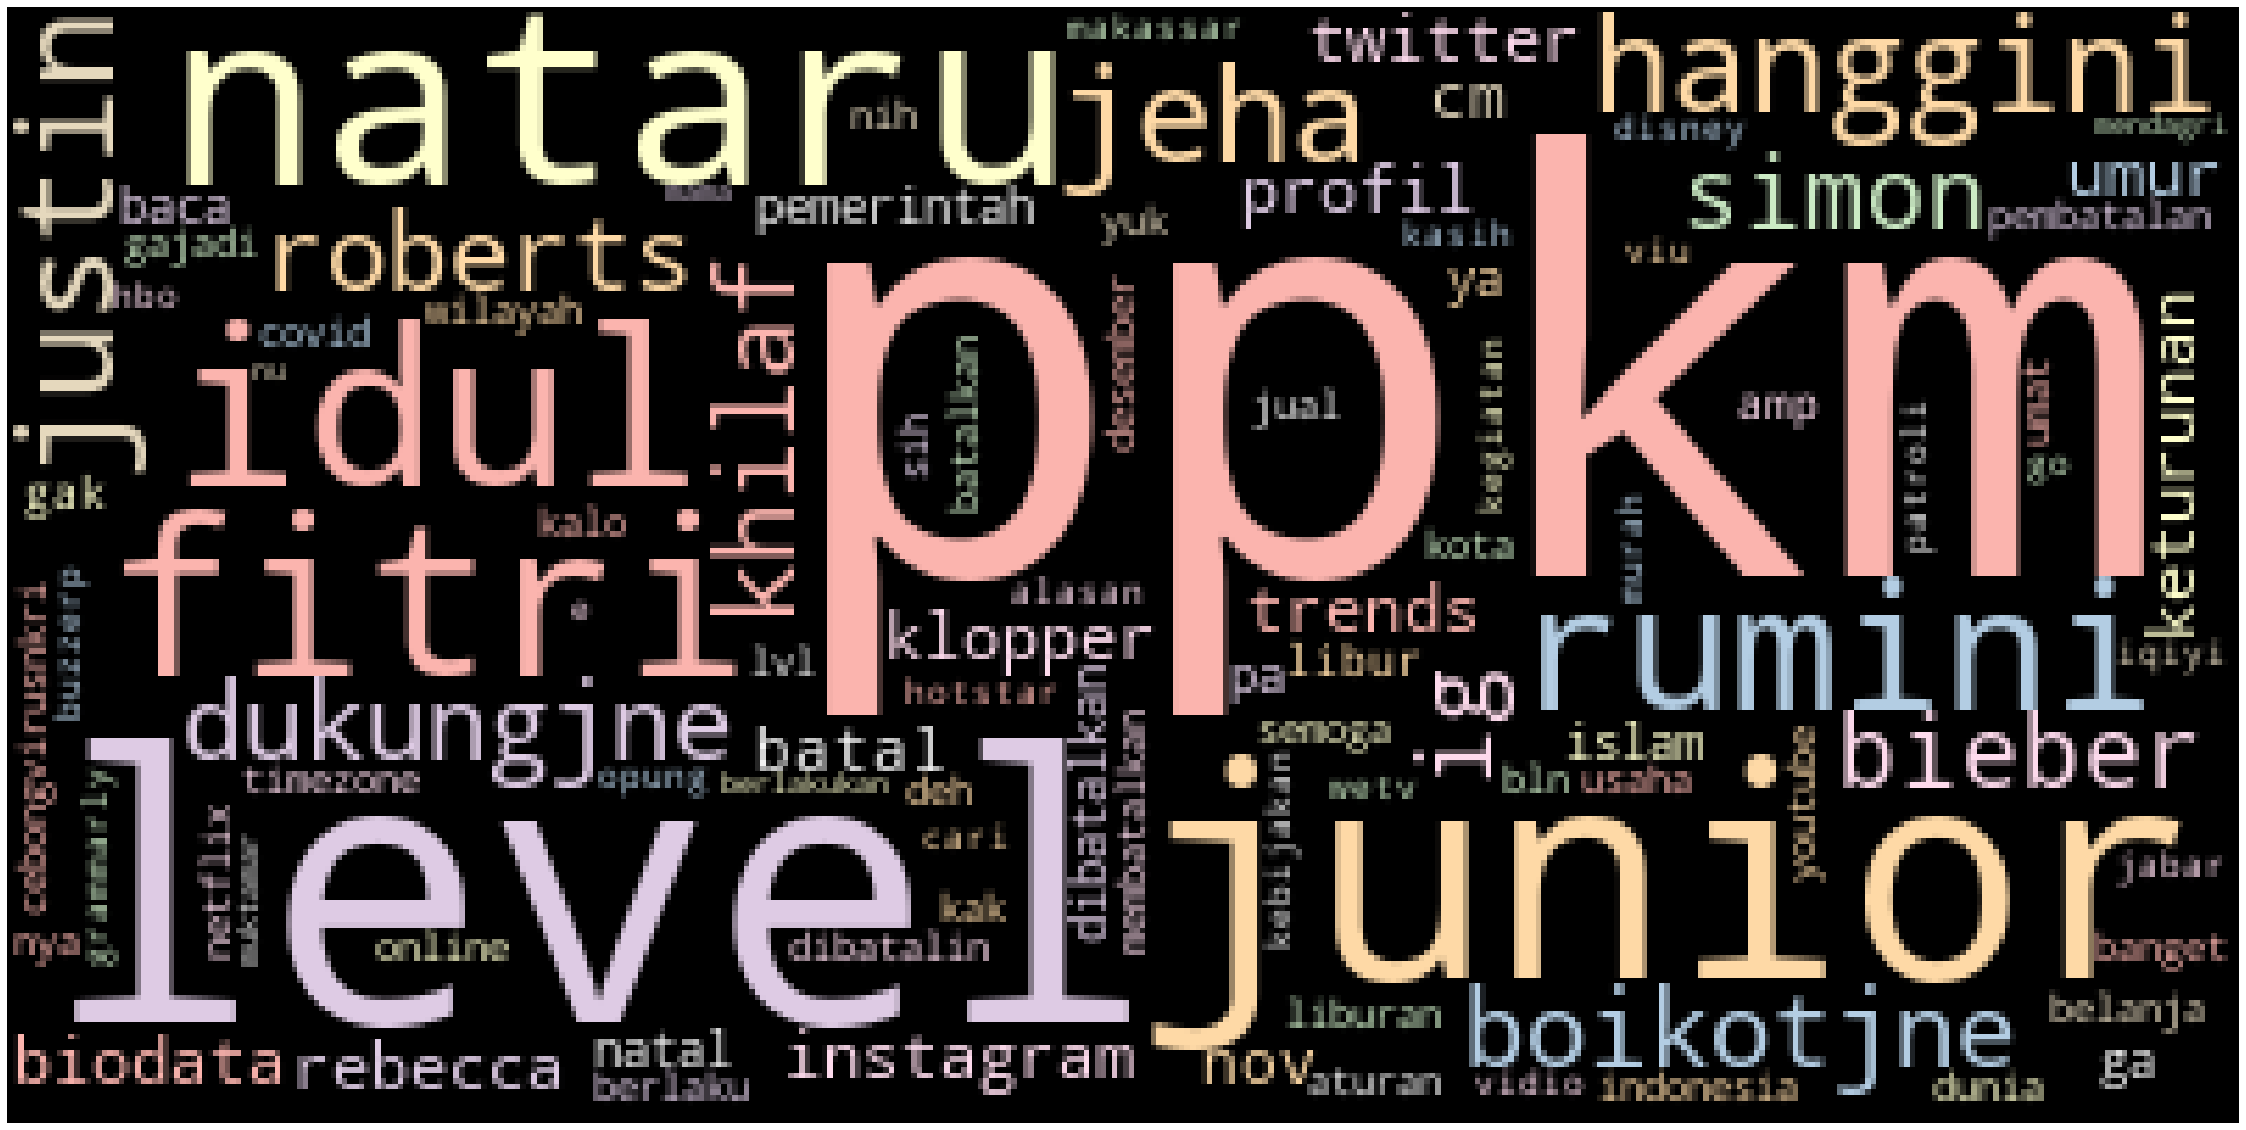

In [12]:
# 1. Menampilkan teks analisis

# Distribusi Frekuensi karakter per tweet
analyze.showFqCharPerTweet()
# Distribusi panjang kata per tweet
analyze.showNumWordPerTweet()
# Distribusi panjang rata-rata kata per tweet
analyze.showAvgWordPerTweet()
# Distribusi Kata
analyze.freqWordDist()
# Word Cloud
analyze.genWordCloud()
# Distribusi N-Gram
analyze.nGramsDist()


*Catatan :*

Berdasarkan frekuensi kata, word cloud dan distribusi n-gram terdapat beberapa kata yang nampaknya perlu dihilangkan. antara lain :
- kata slang atau stop words seperti : ya, kalo, udah, gk, gue, bgt, kalo, dah, tgl. Untuk kata penghubung, akan dihilangkan sedangkan kata yang memiliki peran pada sentimen, dikonversi menjadi bahasa indonesia yang baik.

<!-- - Muncul kata "matesih" pada retweet, setelah diperiksa, ada tweet yang berulang (bukan berasal dari retweet, karena pada saat request telah difilter terlebih dahulu). Oleh karena itu, baris tersebut akan dihilangkan dari data, dan disisakan hanya satu tweet saja. -->

Distribusi Frekuensi kata yang sering keluar


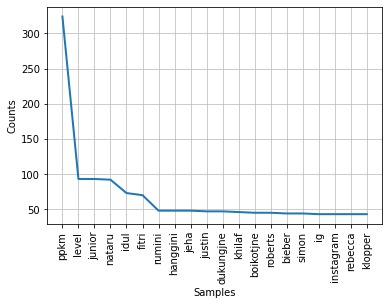

#Distribusi N-gram (n=2)
(ppkm, level)             88
(idul, fitri)             70
(junior, roberts)         45
(junior, ppkm)            44
(justin, bieber)          44
(hanggini, junior)        44
(simon, nataru)           43
(bieber, rumini)          43
(dukungjne, justin)       43
(boikotjne, dukungjne)    43
(fitri, simon)            43
(rumini, idul)            43
(ppkm, boikotjne)         43
(khilaf, hanggini)        43
(jeha, khilaf)            43
(trends, jeha)            43
(nataru, junior)          43
(rebecca, klopper)        43
(ig, instagram)           43
(profil, biodata)         41
dtype: int64


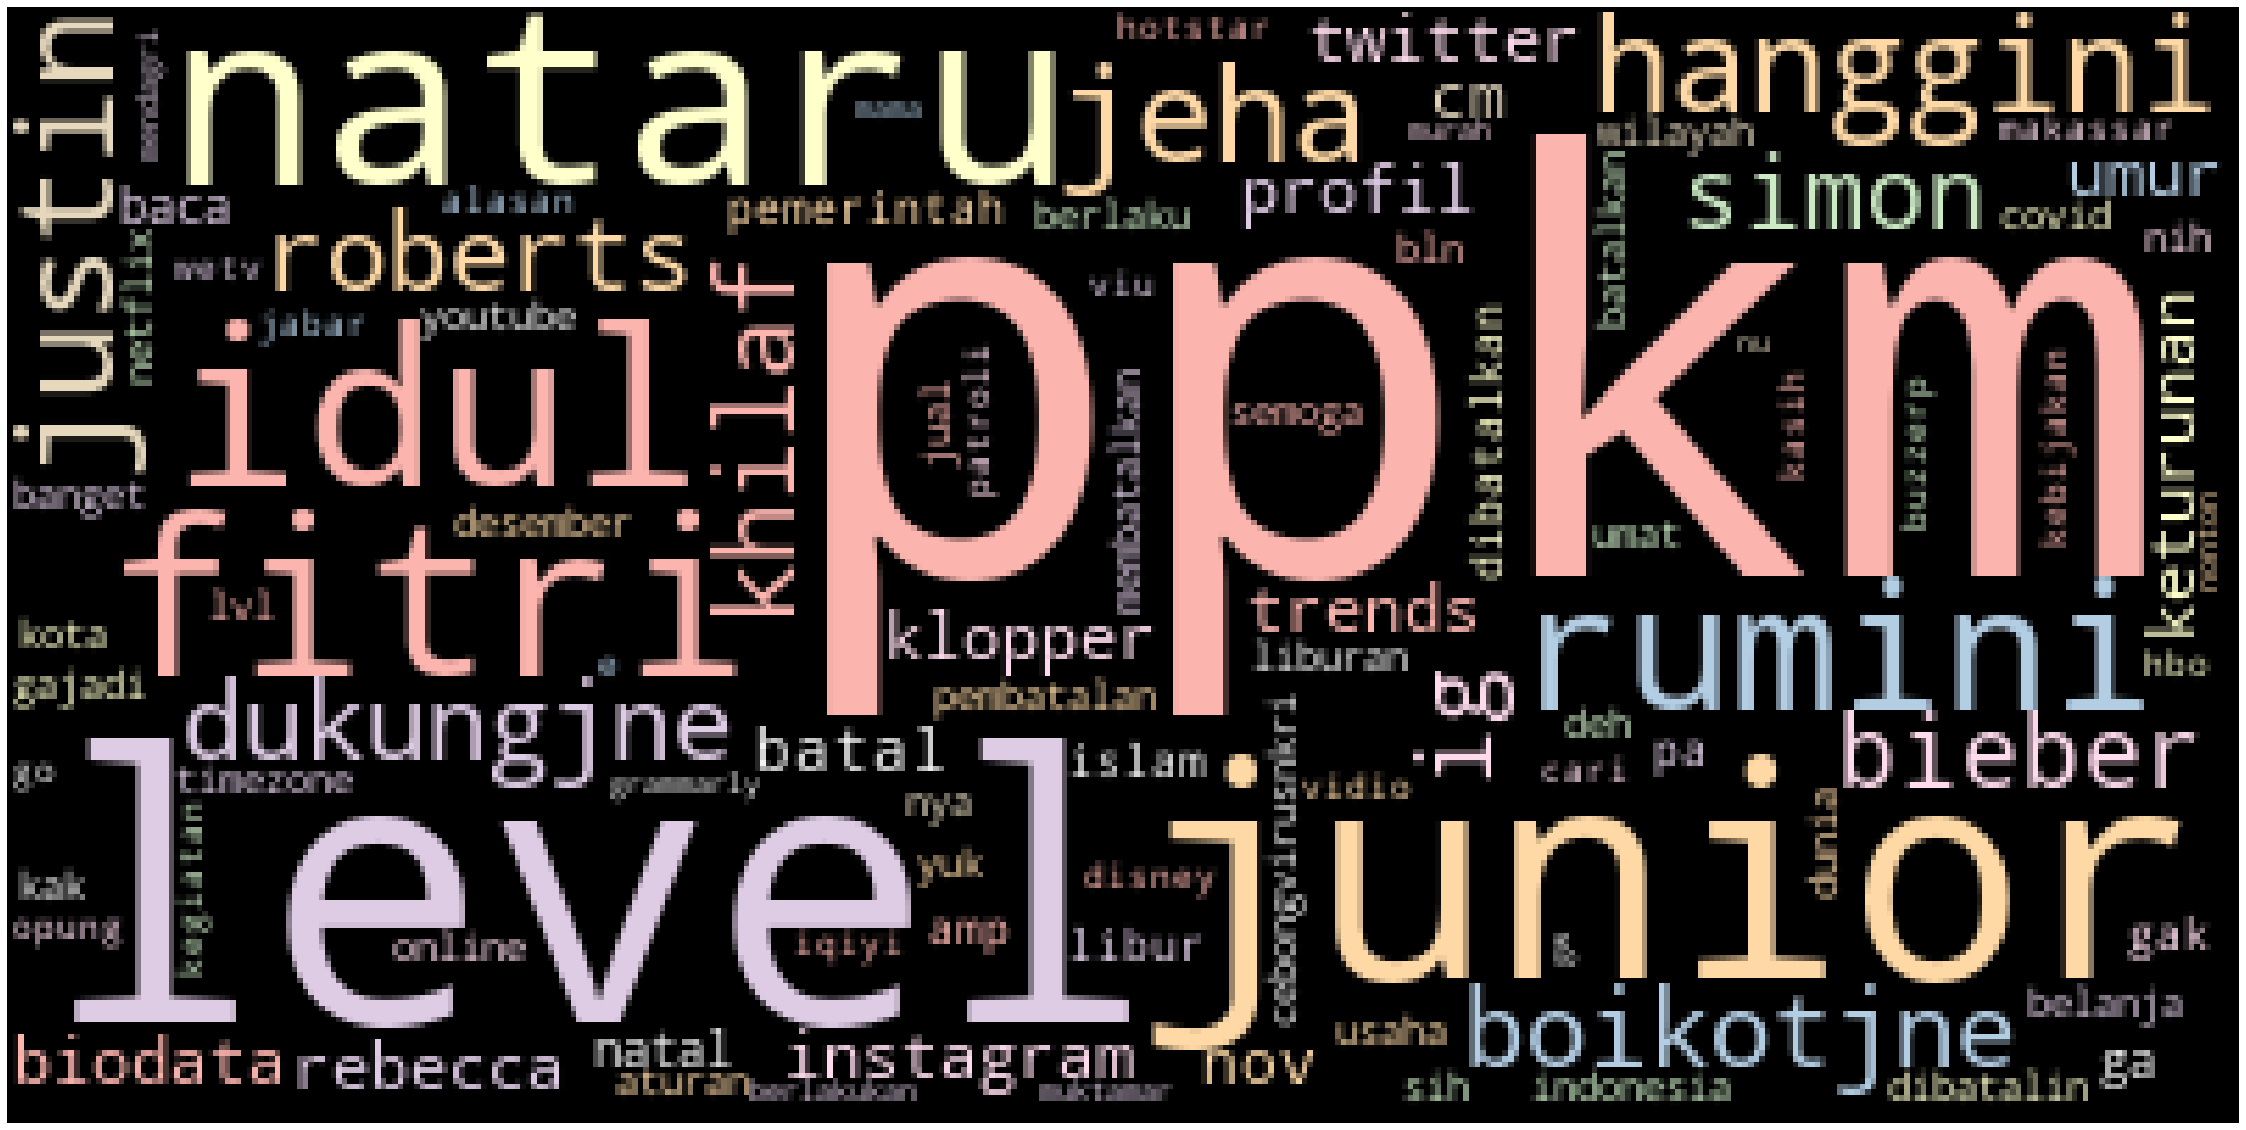

In [13]:
# remove / replace slang
slangs = {
    "ya": "", 
    "kalo": "", 
    "udah": "",
    "gk": "tidak", 
    "gue": "", 
    "bgt": "", # saya kurang yakin apakah menunjukkan banget atau begitu 
    "dah": "", 
    "tgl": "tanggal"
}
analyze.replaceSlang(slangs=slangs)

# Distribusi Kata
analyze.freqWordDist()
# Word Cloud
analyze.genWordCloud()
# Distribusi N-Gram
analyze.nGramsDist()


Setelah dilakukan pembersihan beberapa kata, kita mendapatkan beberapa kata-kata baru yang masuk ke dalam 20 kata yang paling banyak digunakan. baik pada word count atau distribusi n-gram bisa kita peroleh warganet membicarakan mengenai kebijakan pemerintah berkaitan ppkm khususnya yang ditetapkan pada jawa-bali pada libur natal dan awal tahun baru (nataru). Pada perbincangan itu muncul ajakan kepada masyarakat untuk mematuhi protokol kesehatan.  

### Part 3 : Sentiment Analysis

Instruksi Soal :

- Lakukan Sentiment Analysis 
- masukkan hasilnya pada dataframe dengan nama kolom "sentiment"



In [14]:
def readList(fileName):
    tFile = open(fileName, "r")
    result = tFile.readlines()    
    return [word.strip() for word in result]    

negations = ['tidak','lawan','anti', 'jangan', 'bukan', 'sulit', 'tak']
positiveWord = readList(f"{basePath}/kata_positif.txt")
negativeWord = readList(f"{basePath}/kata_negatif.txt")

sentimentValues = []

def getSentiment(text):
    splittedText = text.split()
    numPositive = 0
    numNegative = 0

    for idx, word in enumerate(splittedText):
        # loop positive word
        for positive in positiveWord:
            if (positive==word):
                if (splittedText[idx-1] in negations):
                    numNegative+=1
                    # print(splittedText[idx-1], positive, ": negative")
                else :
                    numPositive+=1
                    # print(positive, ": positive")
        
        for negative in negativeWord:
            if (negative==word):
                if (splittedText[idx-1] in negations):
                    numPositive+=1
                    # print(splittedText[idx-1], negative, ": positive")
                else :
                    numNegative+=1
                    # print(negative, ": negative")

    # print("positive", numPositive)
    # print("negative", numNegative)
    value = numPositive-numNegative
    sentimentValues.append(value)
    return "positive" if value>=0 else "negative" 

analyze.df["sentiment"] = analyze.df["tweet_clean"].apply(getSentiment)
analyze.df["sValue"] = sentimentValues
analyze.df[["tweet", "tweet_clean","sValue", "sentiment"]]


,tweet,tweet_clean,sValue,sentiment
0,"ppkm batal. sesuk nak kasus e munggah meneh, tenan aku arep JIM sik dadi warga negara. arep fokus belajar bahasa korea.",ppkm batal sesuk nak e munggah meneh tenan arep jim sik dadi warga negara arep fokus belajar bahasa korea,0,positive
1,PPKM Level 3 diundur sampe menjelang Ramadhan dan Idul Fitri nanti..🙊🙊 https://t.co/ohmSaTZfFw,ppkm level diundur sampe menjelang ramadhan idul fitri,0,positive
2,oh gajadi ppkm takut ora iso nyekar ke tmpt opung,oh gajadi ppkm takut ora iso nyekar tmpt opung,-1,negative
3,"Bersama Forkopimda Palas, Dandim 0212/Tapsel Laksanakan Rapat Evaluasi PPKM dan Vaksinasi https://t.co/i0Mh847RZT",forkopimda palas dandim tapsel laksanakan rapat evaluasi ppkm vaksinasi,1,positive
4,Kebijakan PPKM level 3 di seluruh wilayah Indonesia saat Natal dan Tahun Baru dibatalkan. Bagaimana nasib libur semester ganjil? Via: detikedu https://t.co/PaMv6INLes,kebijakan ppkm level wilayah indonesia natal dibatalkan nasib libur semester ganjil via detikedu,-2,negative
...,...,...,...,...
295,@tempodotco PPKM sama kaga PPKM kga ngaruh tetep ajah pendapatan runyem,ppkm kaga ppkm kga ngaruh tetep ajah pendapatan runyem,0,positive
296,DISKRIMINASI LEVEL 3 !!!!\n\nPemerintah Tidak Jadi Berlakukan PPKM Level 3 Selama Libur Natal dan Tahun Baru 2022 https://t.co/sAMnStqe1g,diskriminasi level pemerintah berlakukan ppkm level libur natal,-1,negative
297,Pemerintah Batal Terapkan PPKM Level 3 Seluruh Indonesia Saat Nataru \n\nhttps://t.co/UzZL8rJiIL,pemerintah batal terapkan ppkm level indonesia nataru,-1,negative
298,Selasa JNE Memberi PPKM Nataru Genangan Rumini Lebaran Idul Fitri Basarnas \n\n#IndonesiaUntukSemeru\n#KadrunHamaNKRI https://t.co/T7wo4nDGHN,selasa jne ppkm nataru genangan rumini lebaran idul fitri basarnas indonesiauntuksemeru kadrunhamankri,0,positive


Nilai rata-rata: -0.24333333333333335
Standar deviasi: 1.2796310232076884


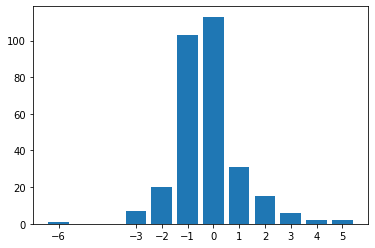

In [15]:
#lakukan analisis dan tarik kesimpulan dari Text analysis dan Sentiment Analysis
#masukkan analisis kalian pada sel berikut.

print (f"Nilai rata-rata: {np.mean(sentimentValues)}")
print (f"Standar deviasi: {np.std(sentimentValues)}")

labels, counts = np.unique(sentimentValues, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

*Analisis*

- Dengan nilai rata-rata sentiment 0.07, warganet cenderung memiliki sentimen positif atas kebijakan ppkm
- Standar deviasi nilai sentiment adalah 0.98, hal ini menunjukkan secara umum data tidak memiliki penyimpangan yang jauh dari nilai rata-rata
- Sebaran sentimen, terdistribusi normal dengan, namun mayoritas datanya cenderung memiliki nilai 0. 